# Data Analysis of Movies by Rating Relative to Age

In [25]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
import category_encoders as ce 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import datetime as dt
import numpy as np
import pandas as pd
import re

In [95]:
 InteractiveShell.ast_node_interactivity = "all" #Pretty-prints output function calls without need for print()

In [3]:
# Data source: https://grouplens.org/datasets/movielens/20m/
# Successfully matched MD5 checksum with reference provided (data verified)

movies_mstr = pd.read_csv('/Users/Levient/Movie_Ratings/ml-20m/movies.csv')
ratings_mstr = pd.read_csv('/Users/Levient/Movie_Ratings/ml-20m/ratings.csv')

movies_mstr.head()
ratings_mstr.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


### Parse Genres

In [4]:
# Reusable split_column function splits the genres column. Returns a new df containing one new row for each genre.

genre_values = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']

def split_column(df, column, enums, sep = '|'):
    indices = list()
    new_values = list()
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        for value in values:
            indices.append(i)
            new_values.append(value)
    new_df = df.iloc[indices, :].copy()
    new_df[column] = pd.Categorical(new_values, categories=enums)
    return new_df

movie_genres = split_column(movies_mstr, 'genres', genre_values)

movie_genres.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


# Genres Overview

In [5]:
# Calculate number and percentage of each age

genre_counts = movie_genres.groupby('genres')['movieId'].count()
genre_percentages = genre_counts.groupby(level=0).apply(lambda x: 100 * x / 26744)

print('Totals Counts for Each Genre\n', genre_counts)
print('\nPercentages for Each Genre\n', genre_percentages)

Totals Counts for Each Genre
 genres
Action                 3520
Adventure              2329
Animation              1027
Children               1139
Comedy                 8374
Crime                  2939
Documentary            2471
Drama                 13344
Fantasy                1412
Film Noir                 0
Horror                 2611
Musical                1036
Mystery                1514
Romance                4127
Sci-Fi                 1743
Thriller               4178
War                    1194
Western                 676
(no genres listed)      246
Name: movieId, dtype: int64

Percentages for Each Genre
 genres
Action                13.161831
Adventure              8.708495
Animation              3.840114
Children               4.258899
Comedy                31.311696
Crime                 10.989381
Documentary            9.239456
Drama                 49.895304
Fantasy                5.279689
Film Noir              0.000000
Horror                 9.762937
Musical        

In [6]:
# All rows for 'movieId' and 'rating'

ratings = ratings_mstr[['movieId', 'rating']]
movies = movies_mstr[['movieId', 'title']]

ratings.head()
movies.head()

,movieId,rating
0,2,3.5
1,29,3.5
2,32,3.5
3,47,3.5
4,50,3.5


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [7]:
# Average all ratings per movie and add 'average' column

# The below ratings.loc function yields a 'chained_assignment' warning (not an error), despite use of df.loc[]. 
# The issue should probably be revisited: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

pd.options.mode.chained_assignment = None  # default='warn'

ratings.loc[:,'average'] = ratings.groupby('movieId')['rating'].transform('mean')

print('Average Ratings for All Movies')
ratings.head()

Average Ratings for All Movies


,movieId,rating,average
0,2,3.5,3.211977
1,29,3.5,3.952230
2,32,3.5,3.898055
3,47,3.5,4.053493
4,50,3.5,4.334372


In [8]:
# Remove duplicate ratings rows from ratings, drop rating column

print('Before\n', ratings.shape)

average_ratings = ratings.drop_duplicates(subset=['movieId', 'average']).drop(columns=['rating'])

print('After\n', average_ratings.shape)
print('Total movies\n', movies.shape)
print('Averages')
average_ratings.head()

# Issue to explore: There are more movies than there are average reviews. 

Before
 (20000263, 3)
After
 (26744, 2)
Total movies
 (27278, 2)
Averages


,movieId,average
0,2,3.211977
1,29,3.952230
2,32,3.898055
3,47,4.053493
4,50,4.334372


# Ratings Overview

Median of Average Ratings
 3.235294117647059 
Mean of Average Ratings
 3.1331999901257013


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fdccac8>]],
      dtype=object)

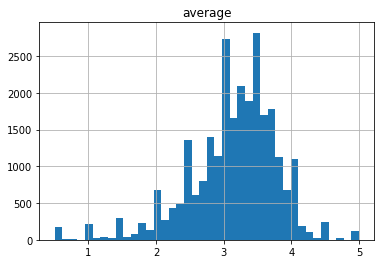

In [9]:
# Find median (and mean) of all ratings

avg_ratings_median = average_ratings['average'].median()
avg_ratings_mean = average_ratings['average'].mean()

print('Median of Average Ratings\n', avg_ratings_median, '\nMean of Average Ratings\n', avg_ratings_mean)
average_ratings.hist(bins=40, column=['average'])

In [10]:
# Sorting movies by average rating

average_ratings = average_ratings.sort_values(by=['average'], ascending=False)

average_ratings.head()
average_ratings.tail()

,movieId,average
17018985,105529,5.0
13119523,115994,5.0
19563933,95517,5.0
19563918,94972,5.0
13522983,113043,5.0


,movieId,average
13890305,129881,0.5
11137143,88742,0.5
13890304,129879,0.5
13890303,129877,0.5
14398624,73196,0.5


In [11]:
# Apply 'Best', 'Worst', 'OK' to 'popularity' as quintiles using qcut

average_ratings['popularity'] = pd.qcut(average_ratings['average'], 5, labels=['Worst', 'lower', 'OK', 'upper', 'Best'])

average_ratings.shape
average_ratings.head()
average_ratings.tail()

(26744, 3)

,movieId,average,popularity
17018985,105529,5.0,Best
13119523,115994,5.0,Best
19563933,95517,5.0,Best
19563918,94972,5.0,Best
13522983,113043,5.0,Best


,movieId,average,popularity
13890305,129881,0.5,Worst
11137143,88742,0.5,Worst
13890304,129879,0.5,Worst
13890303,129877,0.5,Worst
14398624,73196,0.5,Worst


### Divide into popularity buckets, "Best", "Worst", "OK"

In [12]:
# Drop 'upper' and 'lower' popularity scores. Keep only 'Best', 'Worst' and 'OK'

popularity_trio = average_ratings.loc[average_ratings['popularity'].isin(['Best', 'Worst', 'OK'])]

print('Before', average_ratings.shape)
print('After', popularity_trio.shape)
popularity_trio.head()
popularity_trio.tail()

Before (26744, 3)
After (16202, 3)


,movieId,average,popularity
17018985,105529,5.0,Best
13119523,115994,5.0,Best
19563933,95517,5.0,Best
19563918,94972,5.0,Best
13522983,113043,5.0,Best


,movieId,average,popularity
13890305,129881,0.5,Worst
11137143,88742,0.5,Worst
13890304,129879,0.5,Worst
13890303,129877,0.5,Worst
14398624,73196,0.5,Worst


In [13]:
# The classify_age function extracts a year in parens from 'title(year)' and returns a string (e.g. 'old') 

def classify_age(row):
    year = extract_year(row)
    return assign_age(year)

def extract_year(row):
    year_in_parens = re.compile('(?<=\()(\d{4})(?=\))')
    result = year_in_parens.search(row['title'])
    if result:
        return result.group(0)
    else: 
        return None

def assign_age(year):
    if year == None:
        return 'Unknown'
    year = dt.datetime(int(year), 1, 1)
    if year < dt.datetime(1970, 1, 1):
        return 'old'
    elif year < dt.datetime(1990, 1, 1):
        return 'medium'
    else:
        return 'new'

In [14]:
# Applying classify_age returns a new column 'age' with 4 classes: 'old', 'medium', 'new', 'unknown'
# Using categorical data for ease of sorting/visualizing

age_categories = ['new', 'medium', 'old']
ages = movies.apply(classify_age, axis=1)

movies['age'] = pd.Categorical(ages, categories=age_categories, ordered=True)

movies.head(5)

,movieId,title,age
0,1,Toy Story (1995),new
1,2,Jumanji (1995),new
2,3,Grumpier Old Men (1995),new
3,4,Waiting to Exhale (1995),new
4,5,Father of the Bride Part II (1995),new


# Ages Overview

In [15]:
# Calculate number and percentage of each age

age_counts = movies.groupby('age')['movieId'].count()
percentages = age_counts.groupby(level=0).apply(lambda x: 100 * x / 26744)

print('Totals Counts of Each Age\n', age_counts)
print('\nPercentages of Each Age\n', percentages)

Totals Counts of Each Age
 age
new       17118
medium     4674
old        5464
Name: movieId, dtype: int64

Percentages of Each Age
 age
new       64.006880
medium    17.476817
old       20.430751
Name: movieId, dtype: float64


# Merging Data Before Analysis

In [16]:
# Prepare to merge data by dropping title from movie_genres

genres = movie_genres.drop(['title'], axis=1)

# Inner join movies, ratings and genres on 'movieId'

movie_ratings = pd.merge(movies, popularity_trio, on='movieId')
movie_genre_ratings = pd.merge(movie_ratings, genres, on='movieId')

movie_genre_ratings.head()
movie_genre_ratings.tail()

,movieId,title,age,average,popularity,genres
0,1,Toy Story (1995),new,3.92124,Best,Adventure
1,1,Toy Story (1995),new,3.92124,Best,Animation
2,1,Toy Story (1995),new,3.92124,Best,Children
3,1,Toy Story (1995),new,3.92124,Best,Comedy
4,1,Toy Story (1995),new,3.92124,Best,Fantasy


,movieId,title,age,average,popularity,genres
32173,131256,"Feuer, Eis & Dosenbier (2002)",new,4.0,Best,Comedy
32174,131258,The Pirates (2014),new,2.5,Worst,Adventure
32175,131262,Innocence (2014),new,4.0,Best,Adventure
32176,131262,Innocence (2014),new,4.0,Best,Fantasy
32177,131262,Innocence (2014),new,4.0,Best,Horror


In [99]:
# Re-order columns for ease of use
movie_genre_ratings = movie_genre_ratings[['movieId', 'average', 'age', 'genres', 'popularity', 'title']]

movie_genre_ratings.head()
movie_genre_ratings.shape

,movieId,average,age,genres,popularity,title
0,1,3.92124,new,Adventure,Best,Toy Story (1995)
1,1,3.92124,new,Animation,Best,Toy Story (1995)
2,1,3.92124,new,Children,Best,Toy Story (1995)
3,1,3.92124,new,Comedy,Best,Toy Story (1995)
4,1,3.92124,new,Fantasy,Best,Toy Story (1995)


(32178, 6)

## Pre-processing Data 

In [102]:
# Converting categorical data to be consumed by Scikit-Learn

X = movie_genre_ratings

age_map = [
    {'col': 'age', 
    'mapping': 
        [('new', 1), 
        ('medium', 2), 
        ('old', 3)]
    }]
pop_map = [
    {'col': 'popularity', 
    'mapping': 
        [('Best', 1), 
        ('OK', 2), 
        ('Worst', 3)]
    }]

# Encode 'age' ordinally
ce_ord = ce.OrdinalEncoder(cols = ['age'], mapping=cat_map, handle_unknown='ignore')
X = ce_ord.fit_transform(X)

# Encode 'genres' using OneHot encoding
ce_one_hot = ce.OneHotEncoder(cols = ['genres'], handle_unknown='ignore')
X = ce_one_hot.fit_transform(X)

# Encode 'popularity' ordinally
ce_ord = ce.OrdinalEncoder(cols = ['popularity'], mapping=pop_map, handle_unknown='ignore')
X = ce_ord.fit_transform(X)

# Split into test and prediction groups.
y = X.iloc[:,-2:-1]
X = X.iloc[:,0:-2]



# data_array[:,3] = ord_enc.fit(data_array[:,3]) # Create discrete continuous bins for 'age' 
# data_array[:,5] = est.fit(data_array[:,5]) # Create discrete continuous bins for 'popularity' 
# data_array[:,4] = enc.fit(data_array[:,4]) # Create discrete non-continuous values for 'genres' 

X.head()
y.head()

,genres_1,genres_2,genres_3,genres_4,genres_5,genres_6,genres_7,genres_8,genres_9,genres_10,...,genres_13,genres_14,genres_15,genres_16,genres_17,genres_18,genres_19,movieId,average,age
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1.0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1.0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1.0


,popularity
0,1
1,1
2,1
3,1
4,1


In [59]:
# Setting up basic classification prediction
# Extract 55 percent of our dataset randomly, from which to predict outcomes of remaining 45 percent

np.random.shuffle(data_array)





# "Teach" our machine (SVC) about the relationships between 'average' and 'age'
# (but first we need to reshape our X np_array into a 1-D array)

# svc = SVC()

# v = DictVectorizer()

# X_learning = v.fit_transform(X_learning)
# Y_learning = v.fit_transform(Y_learning)

# svc.fit(X_learning, Y_learning)

# # Use the remaining 45 percent of our data as test data
# X = data_array[-14480:][:,0:5]
# Y = data_array[-14480:][:,5]

# predictions = svc.predict(X)

# print("Predicted Results:", predictions)
# print("\nActual Results:", Y)
# print("\nAccuracy rating:  %f" % (accuracy_score(Y, predictions)))

In [ ]:
# print(confusion_matrix(Y, predictions))
print(classification_report(Y, predictions))